In [196]:
# Imports for data processing 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Imports for ML tasks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import RandomUnderSampler

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [197]:
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

# Get the complete cumulative KOI (Kepler Object of Interest) table
koi_table = NasaExoplanetArchive.query_criteria(
    table="cumulative",   
    select="*",          
    where="koi_disposition IS NOT NULL"  
)

# Convert to pandas DataFrame
koi_df = koi_table.to_pandas()


In [198]:
koi_df.head()

,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,...,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_score,sky_coord.ra,sky_coord.dec
0,10797460,K00752.01,Kepler-227 b,291.93423,0.0,19h27m44.22s,48.141651,0.0,+48d08m29.9s,15.890,...,93.59,29.45,-16.65,3.20796,0.33173,-1.09986,LS+MCMC,1.000,291.93423,48.141651
1,10797460,K00752.02,Kepler-227 c,291.93423,0.0,19h27m44.22s,48.141651,0.0,+48d08m29.9s,15.890,...,9.11,2.87,-1.62,3.02368,2.20489,-2.49638,LS+MCMC,0.969,291.93423,48.141651
2,10811496,K00753.01,,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,39.30,31.04,-10.49,7.29555,35.03293,-2.75453,LS+MCMC,0.000,297.00482,48.134129
3,10848459,K00754.01,,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,891.96,668.95,-230.35,0.22080,0.00917,-0.01837,LS+MCMC,0.000,285.53461,48.285210
4,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,926.16,874.33,-314.24,1.98635,2.71141,-1.74541,LS+MCMC,1.000,288.75488,48.226200


In [199]:
# Print the original columns

print(len(list(koi_df.columns)), 'columns:\n', list(koi_df.columns))

155 columns:
 ['kepid', 'kepoi_name', 'kepler_name', 'ra', 'ra_err', 'ra_str', 'dec', 'dec_err', 'dec_str', 'koi_gmag', 'koi_gmag_err', 'koi_rmag', 'koi_rmag_err', 'koi_imag', 'koi_imag_err', 'koi_zmag', 'koi_zmag_err', 'koi_jmag', 'koi_jmag_err', 'koi_hmag', 'koi_hmag_err', 'koi_kmag', 'koi_kmag_err', 'koi_kepmag', 'koi_kepmag_err', 'koi_delivname', 'koi_vet_stat', 'koi_quarters', 'koi_disposition', 'koi_pdisposition', 'koi_count', 'koi_num_transits', 'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_bin_oedp_sig', 'koi_limbdark_mod', 'koi_ldm_coeff4', 'koi_ldm_coeff3', 'koi_ldm_coeff2', 'koi_ldm_coeff1', 'koi_trans_mod', 'koi_model_snr', 'koi_model_dof', 'koi_model_chisq', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_eccen', 'koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_sma', 'koi_sma_err1', 'koi_sma_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duratio

In [200]:
# Choose a subset of the columns (informed by domain expertise) which are likely to be the most informative 
feature_cols = ['koi_model_snr', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_depth', 'koi_duration',
            'koi_period', 'koi_prad', 'koi_insol', 'koi_steff', 'koi_srad']
koi_predictive = koi_df[feature_cols + ['koi_disposition']]

# Remove all rows with null values in any of the feature columns
koi_cleaned = koi_predictive.dropna()

# Check the value counts
koi_cleaned.koi_disposition.value_counts()

koi_disposition
FALSE POSITIVE    4582
CONFIRMED         2743
CANDIDATE         1876
Name: count, dtype: int64

In [201]:
# Separate into two databases - one for testing and training, one for predicitions
koi_tt = koi_cleaned[koi_cleaned['koi_disposition'].isin(['FALSE POSITIVE', 'CONFIRMED'])]
koi_p = koi_cleaned[koi_cleaned['koi_disposition'] == 'CANDIDATE']

# Check that databases properly separated
print('Test/Train:\n', koi_tt.koi_disposition.value_counts())
print('\nPredict:\n', koi_p.koi_disposition.value_counts())

# Drop 'koi_disposition' from koi_p since all are 'CANDIDATE'
koi_p.drop(columns=['koi_disposition'], inplace=True)


Test/Train:
 koi_disposition
FALSE POSITIVE    4582
CONFIRMED         2743
Name: count, dtype: int64

Predict:
 koi_disposition
CANDIDATE    1876
Name: count, dtype: int64


Note that FP/Confirmed is not super imbalanced, so we probably won't need to use imbalance measures like upsampling/weighting/etc, but worth a mention

In [202]:
# Create list of float columns to be scaled (integer columns are one-hot encodings)
float_cols = list(koi_tt.select_dtypes(include='float64').columns)

# Initialize scaler
scaler = StandardScaler()

# Fit and transform only float columns in test/train data
koi_tt.loc[:, float_cols] = scaler.fit_transform(koi_tt[float_cols])

# Only transform (do not re-fit) float columns in prediction (unseen) data
koi_p.loc[:, float_cols] = scaler.transform(koi_p[float_cols])

koi_tt.head()

,koi_model_snr,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_depth,koi_duration,koi_period,koi_prad,koi_insol,koi_steff,koi_srad,koi_disposition
0,-0.320999,0,0,0,0,-0.317181,-0.406731,-0.364595,-0.032046,-0.051892,-0.318508,-0.131476,CONFIRMED
1,-0.332348,0,0,0,0,-0.314340,-0.180298,0.041698,-0.031867,-0.052365,-0.318508,-0.131476,CONFIRMED
3,0.212204,0,1,0,0,-0.235318,-0.487264,-0.434685,-0.022236,-0.047423,0.108725,-0.153135,FALSE POSITIVE
4,-0.315211,0,0,0,0,-0.317318,-0.597142,-0.427554,-0.031892,-0.047231,0.384595,-0.112525,CONFIRMED
5,-0.286156,0,0,0,0,-0.307291,-0.167512,-0.350069,-0.031530,-0.051773,0.402904,-0.124310,CONFIRMED


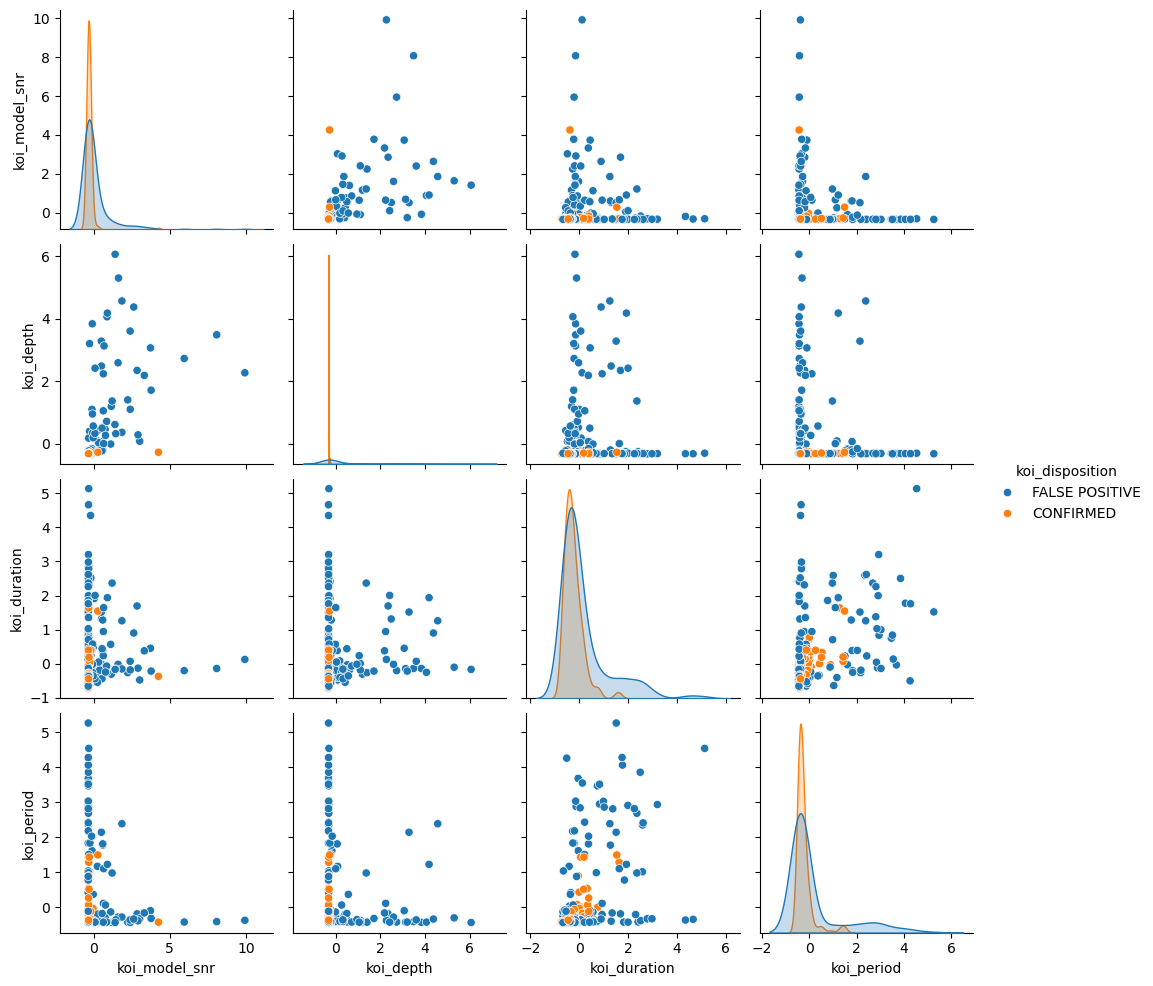

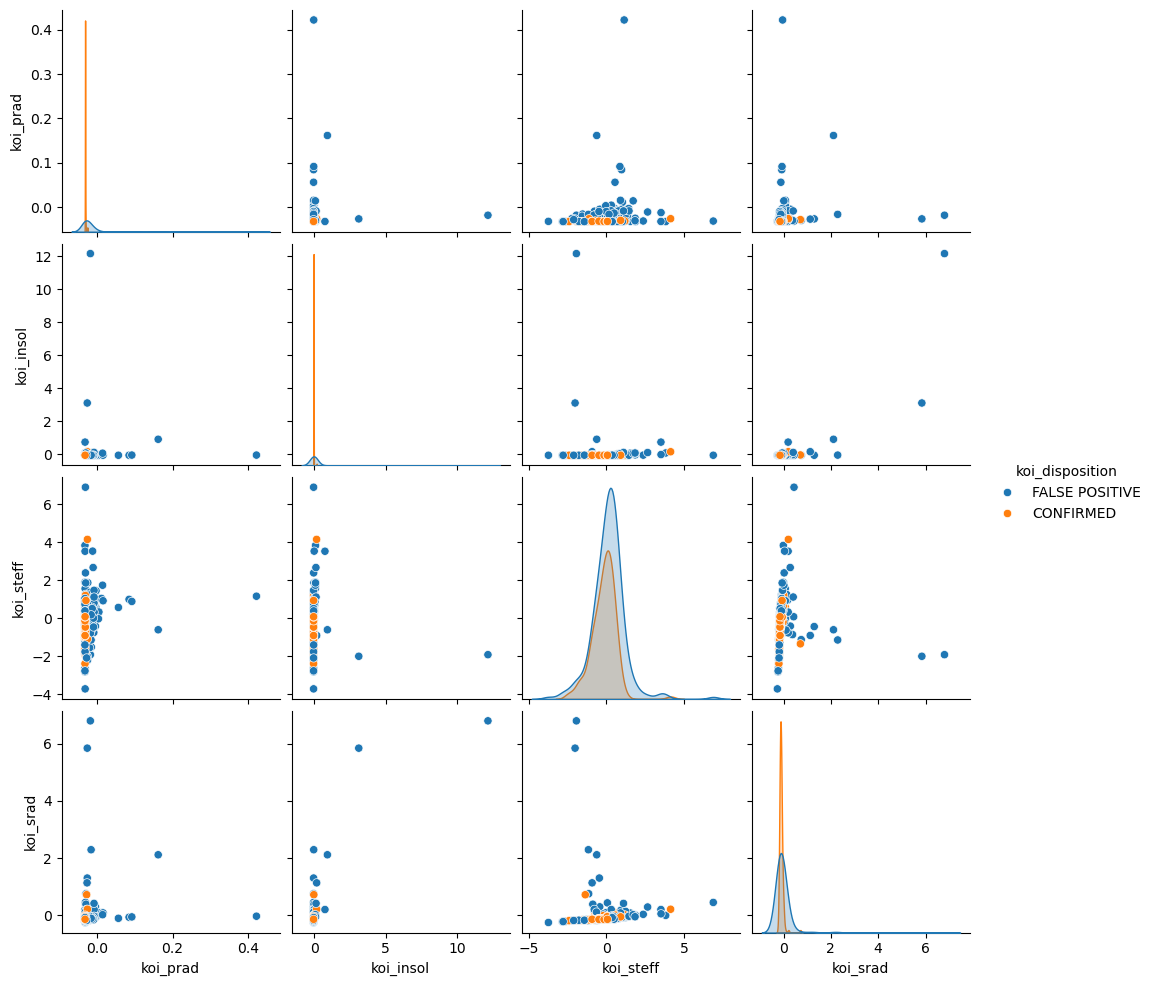

In [63]:
# Downsample for plotting
koi_downsampled = koi_tt.sample(frac=0.05, random_state=42)

# Generate two pairplots of float columns (separate into two figures for ease of visualisation)
pairplot1 = sns.pairplot(koi_downsampled[float_cols[:4] + ['koi_disposition']], hue='koi_disposition')
pairplot2 = sns.pairplot(koi_downsampled[float_cols[4:] + ['koi_disposition']], hue='koi_disposition')

# Save to file (e.g., PNG)
pairplot1.savefig("koi_pairplot1.png", dpi=300)
pairplot2.savefig("koi_pairplot2.png", dpi=300)

In [203]:
# Encode the labels as 0 ('FALSE POSITIVE') 1 ('CONFIRMED')
koi_tt['koi_disposition'] = koi_tt['koi_disposition'].map({'FALSE POSITIVE': 0, 'CONFIRMED': 1})
koi_tt.head()

,koi_model_snr,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_depth,koi_duration,koi_period,koi_prad,koi_insol,koi_steff,koi_srad,koi_disposition
0,-0.320999,0,0,0,0,-0.317181,-0.406731,-0.364595,-0.032046,-0.051892,-0.318508,-0.131476,1
1,-0.332348,0,0,0,0,-0.314340,-0.180298,0.041698,-0.031867,-0.052365,-0.318508,-0.131476,1
3,0.212204,0,1,0,0,-0.235318,-0.487264,-0.434685,-0.022236,-0.047423,0.108725,-0.153135,0
4,-0.315211,0,0,0,0,-0.317318,-0.597142,-0.427554,-0.031892,-0.047231,0.384595,-0.112525,1
5,-0.286156,0,0,0,0,-0.307291,-0.167512,-0.350069,-0.031530,-0.051773,0.402904,-0.124310,1


In [217]:
# Separate koi_tt into X, y, train and test sets
X = koi_tt.drop(columns=['koi_disposition'])
y = koi_tt['koi_disposition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=123)

# Check shapes
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (5127, 12) (5127,)
Test: (2198, 12) (2198,)


In [233]:
# Create dictionary to store model results
model_results = []

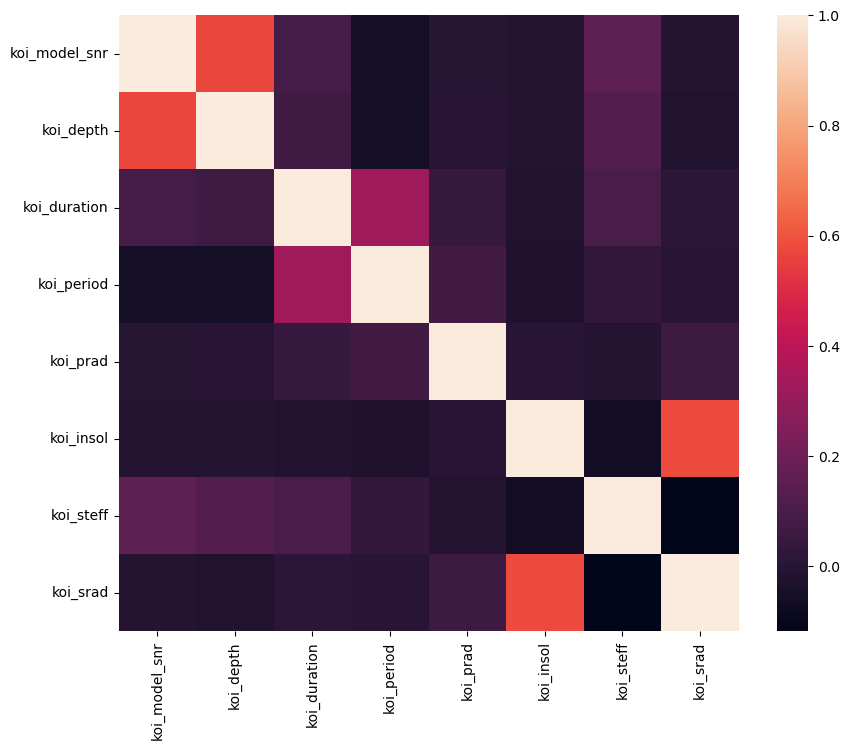

In [234]:
fig, ax = plt.subplots(figsize=(10, 8)) 
sns.heatmap(X[float_cols].corr(), ax=ax)

# Save the figure 
fig.savefig("heatmap_correlation.png", dpi=300, bbox_inches='tight')

plt.show()



# Logistic Regression

In [89]:
# Use GridSearchCV to obtain best hyperparameters for logistic regression

lr_model = LogisticRegression(random_state=123, max_iter=1000)

param_grid = {'penalty': ['l1', 'l2'],
              'solver': ['saga', 'liblinear'],
              'class_weight': ['balanced', None],
              'C': [0.1, 1.0, 10.0]
             }

grid = GridSearchCV(estimator=lr_model, 
                    param_grid=param_grid, 
                    cv = 4,
                    scoring='f1',
                    verbose=2)

grid.fit(X_train, y_train)

grid.best_params_

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.7s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.7s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; total time=   0.5s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; total time=   0.5s
[CV] E

{'C': 10.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

In [235]:
# Create the best logistic regression model
lr_best = LogisticRegression(random_state=123, 
                             max_iter=1000, 
                             C=10.0, 
                             class_weight=None,
                             penalty='l1',
                             solver='liblinear')

# Fit the model using training sets
lr_best.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_best.predict(X_test)

# Evaluate the model using accuracy, precision, recall, f_beta
print('Results: Logistic regression with L1 regularisation:')
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = ', accuracy) 
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
print('Precision = ', precision) 
print('Recall = ', recall) 
print('f1 score = ', f1) 
model_results.append([accuracy, precision[1], recall[1], f1[1]])

Results: Logistic regression with L1 regularisation:
Accuracy =  0.9572338489535942
Precision =  [0.98559515 0.91467577]
Recall =  [0.94545455 0.97691373]
f1 score =  [0.96510765 0.94477086]


In [221]:
# Output the probabilities for each classification
y_probs = lr_best.predict_proba(X_test)
y_probs

array([[9.00623786e-02, 9.09937621e-01],
       [9.68930019e-01, 3.10699815e-02],
       [9.99224624e-01, 7.75375569e-04],
       ...,
       [9.89290689e-01, 1.07093111e-02],
       [9.99998955e-01, 1.04547776e-06],
       [6.68910598e-02, 9.33108940e-01]])

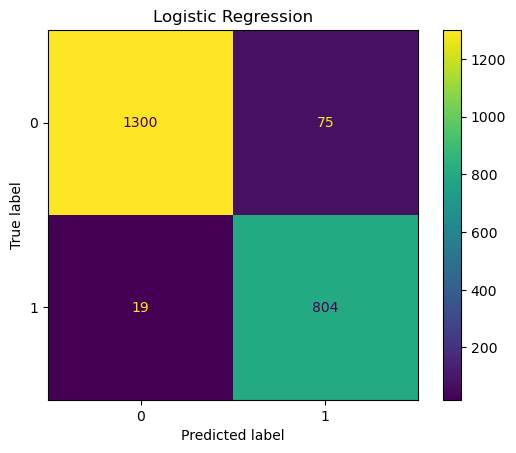

In [222]:
cf = confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=['0', '1'])
disp.plot()
plt.title('Logistic Regression')
plt.savefig("confusion_matrix_logreg.png", dpi=300, bbox_inches='tight')
plt.show()


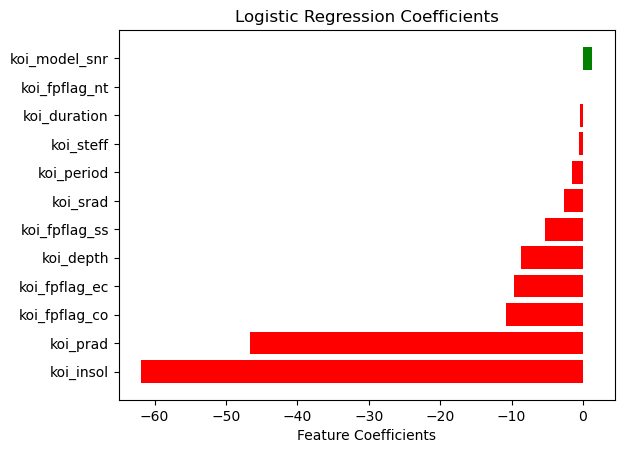

In [211]:
# Generate dictionary of coefficients
coef_dict = {}
for ix, feature in enumerate(feature_cols):
    coef = lr_best.coef_[0, ix]
    coef_dict[feature] = coef

# Sort the coefficients
coef_dict = dict(sorted(coef_dict.items(), key=lambda item: item[1]))

# Specify colour green for positive coefficients, red for negative coefficients
colours = []
for val in coef_dict.values():
    if val < 0:
        colours.append('r')
    else:
        colours.append('g')

# Visualize coefficients
fig, ax = plt.subplots()
features = list(coef_dict.keys())
values = list(coef_dict.values())
y_pos = np.arange(len(features))
ax.barh(y_pos, values, align='center', color=colours)
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.set_xlabel('Feature Coefficients')
ax.set_title('Logistic Regression Coefficients')
plt.savefig("coefficients_logreg.png", dpi=300, bbox_inches='tight')
plt.show()


# K Nearest Neighbours

In [135]:
# Use GridSearchCV to obtain best hyperparameters for KNN

knn_model = KNeighborsClassifier()

param_grid = {'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}

grid = GridSearchCV(estimator=knn_model, 
                    param_grid=param_grid, 
                    cv = 4,
                    scoring='f1',
                    verbose=2)

grid.fit(X_train, y_train)

grid.best_params_


Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.1s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   0.1s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   0.1s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   0.1s
[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=3, p=2, wei

{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

In [236]:
# Create the best KNN model
knn_best = KNeighborsClassifier(n_neighbors=3, 
                                weights='uniform', 
                                p=1)

# Fit the model using training sets
knn_best.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_best.predict(X_test)

# Evaluate the model using accuracy, precision, recall, f_beta
print('Results: KNN with L1 distance:')
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = ', accuracy) 
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
print('Precision = ', precision) 
print('Recall = ', recall) 
print('f1 score = ', f1) 
model_results.append([accuracy, precision[1], recall[1], f1[1]])

Results: KNN with L1 distance:
Accuracy =  0.9909008189262967
Precision =  [0.99272727 0.98784933]
Recall =  [0.99272727 0.98784933]
f1 score =  [0.99272727 0.98784933]


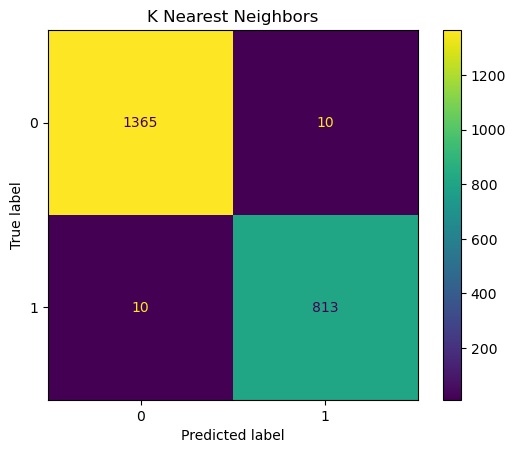

In [224]:
cf = confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=['0', '1'])
disp.plot()
plt.title('K Nearest Neighbors')
plt.savefig("confusion_matrix_knn.png", dpi=300, bbox_inches='tight')
plt.show()

# Support Vector Machine

In [139]:
# Use GridSearchCV to obtain best hyperparameters for SVC

svc_model = SVC()

param_grid = {'C': [1, 10, 50, 100],
              'kernel': ['rbf', 'poly'],
              'gamma': ['scale', 'auto'] 
             }

grid = GridSearchCV(estimator=svc_model, 
                    param_grid=param_grid, 
                    cv = 4,
                    scoring='f1',
                    verbose=2)

grid.fit(X_train, y_train)

grid.best_params_


Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   0.4s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   0.3s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   0.4s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   0.4s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ........................C=1, gamma=auto

{'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}

In [237]:
# Create the best KNN model
svc_best = SVC(C=50, gamma='scale', kernel='rbf')

# Fit the model using training sets
svc_best.fit(X_train, y_train)

# Predict on the test set
y_pred = svc_best.predict(X_test)

# Evaluate the model using accuracy, precision, recall, f_beta
print('Results: SVC with L1 distance:')
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = ', accuracy) 
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
print('Precision = ', precision) 
print('Recall = ', recall) 
print('f1 score = ', f1) 
model_results.append([accuracy, precision[1], recall[1], f1[1]])

Results: SVC with L1 distance:
Accuracy =  0.9931756141947224
Precision =  [0.99707602 0.98674699]
Recall =  [0.992      0.99513973]
f1 score =  [0.99453153 0.99092559]


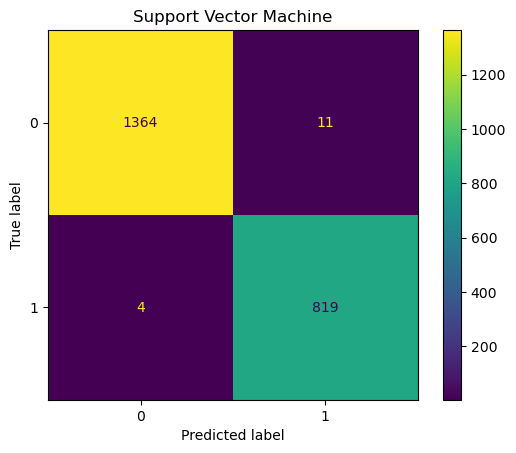

In [226]:
cf = confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=['0', '1'])
disp.plot()
plt.title('Support Vector Machine')
plt.savefig("confusion_matrix_svm.png", dpi=300, bbox_inches='tight')
plt.show()

# Random Forest

In [159]:
# Use GridSearchCV to obtain best hyperparameters for Random Forest

rf_model = RandomForestClassifier(random_state=123)

param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': [10, 15, 20],
              'n_estimators': [10, 25, 50],
              'max_features': [3, 5]
             }

grid = GridSearchCV(estimator=rf_model, 
                    param_grid=param_grid, 
                    cv = 4,
                    scoring='f1',
                    verbose=2)

grid.fit(X_train, y_train)

grid.best_params_


Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV] END criterion=entropy, max_depth=10, max_features=3, n_estimators=10; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=3, n_estimators=10; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=3, n_estimators=10; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=3, n_estimators=10; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=3, n_estimators=25; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=3, n_estimators=25; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=3, n_estimators=25; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=3, n_estimators=25; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=3, n_estimators=50; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=3, n_estimators=50; total time=   0.2

{'criterion': 'gini', 'max_depth': 15, 'max_features': 5, 'n_estimators': 25}

In [238]:
# Create the best Random Forest model
rf_best = RandomForestClassifier(random_state=123, 
                                 criterion='gini', 
                                 max_depth=15, 
                                 max_features=5, 
                                 n_estimators=25)

# Fit the model using training sets
rf_best.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_best.predict(X_test)

# Evaluate the model using accuracy, precision, recall, f_beta
print('Results: Random Forest with 25 Estimators:')
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = ', accuracy) 
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
print('Precision = ', precision) 
print('Recall = ', recall) 
print('f1 score = ', f1) 
model_results.append([accuracy, precision[1], recall[1], f1[1]])

Results: Random Forest with 25 Estimators:
Accuracy =  0.9954504094631483
Precision =  [0.99636364 0.99392467]
Recall =  [0.99636364 0.99392467]
f1 score =  [0.99636364 0.99392467]


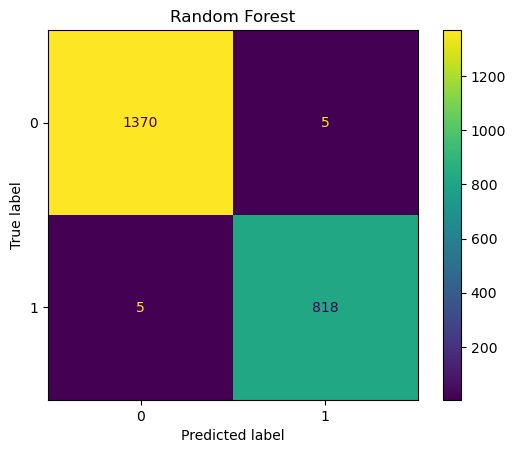

In [230]:
cf = confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=['0', '1'])
disp.plot()
plt.savefig("confusion_matrix_rf.png", dpi=300, bbox_inches='tight')
plt.title('Random Forest')
plt.show()

In [231]:
# Build a single decision tree global surrogate model

tree_surrogate = DecisionTreeClassifier(random_state=123, 
                                         max_depth=5, 
                                         max_features=5)

tree_surrogate.fit(X_test, y_pred)
y_surrogate = tree_surrogate.predict(X_test)

print(accuracy_score(y_pred, y_surrogate))

0.9959053685168335


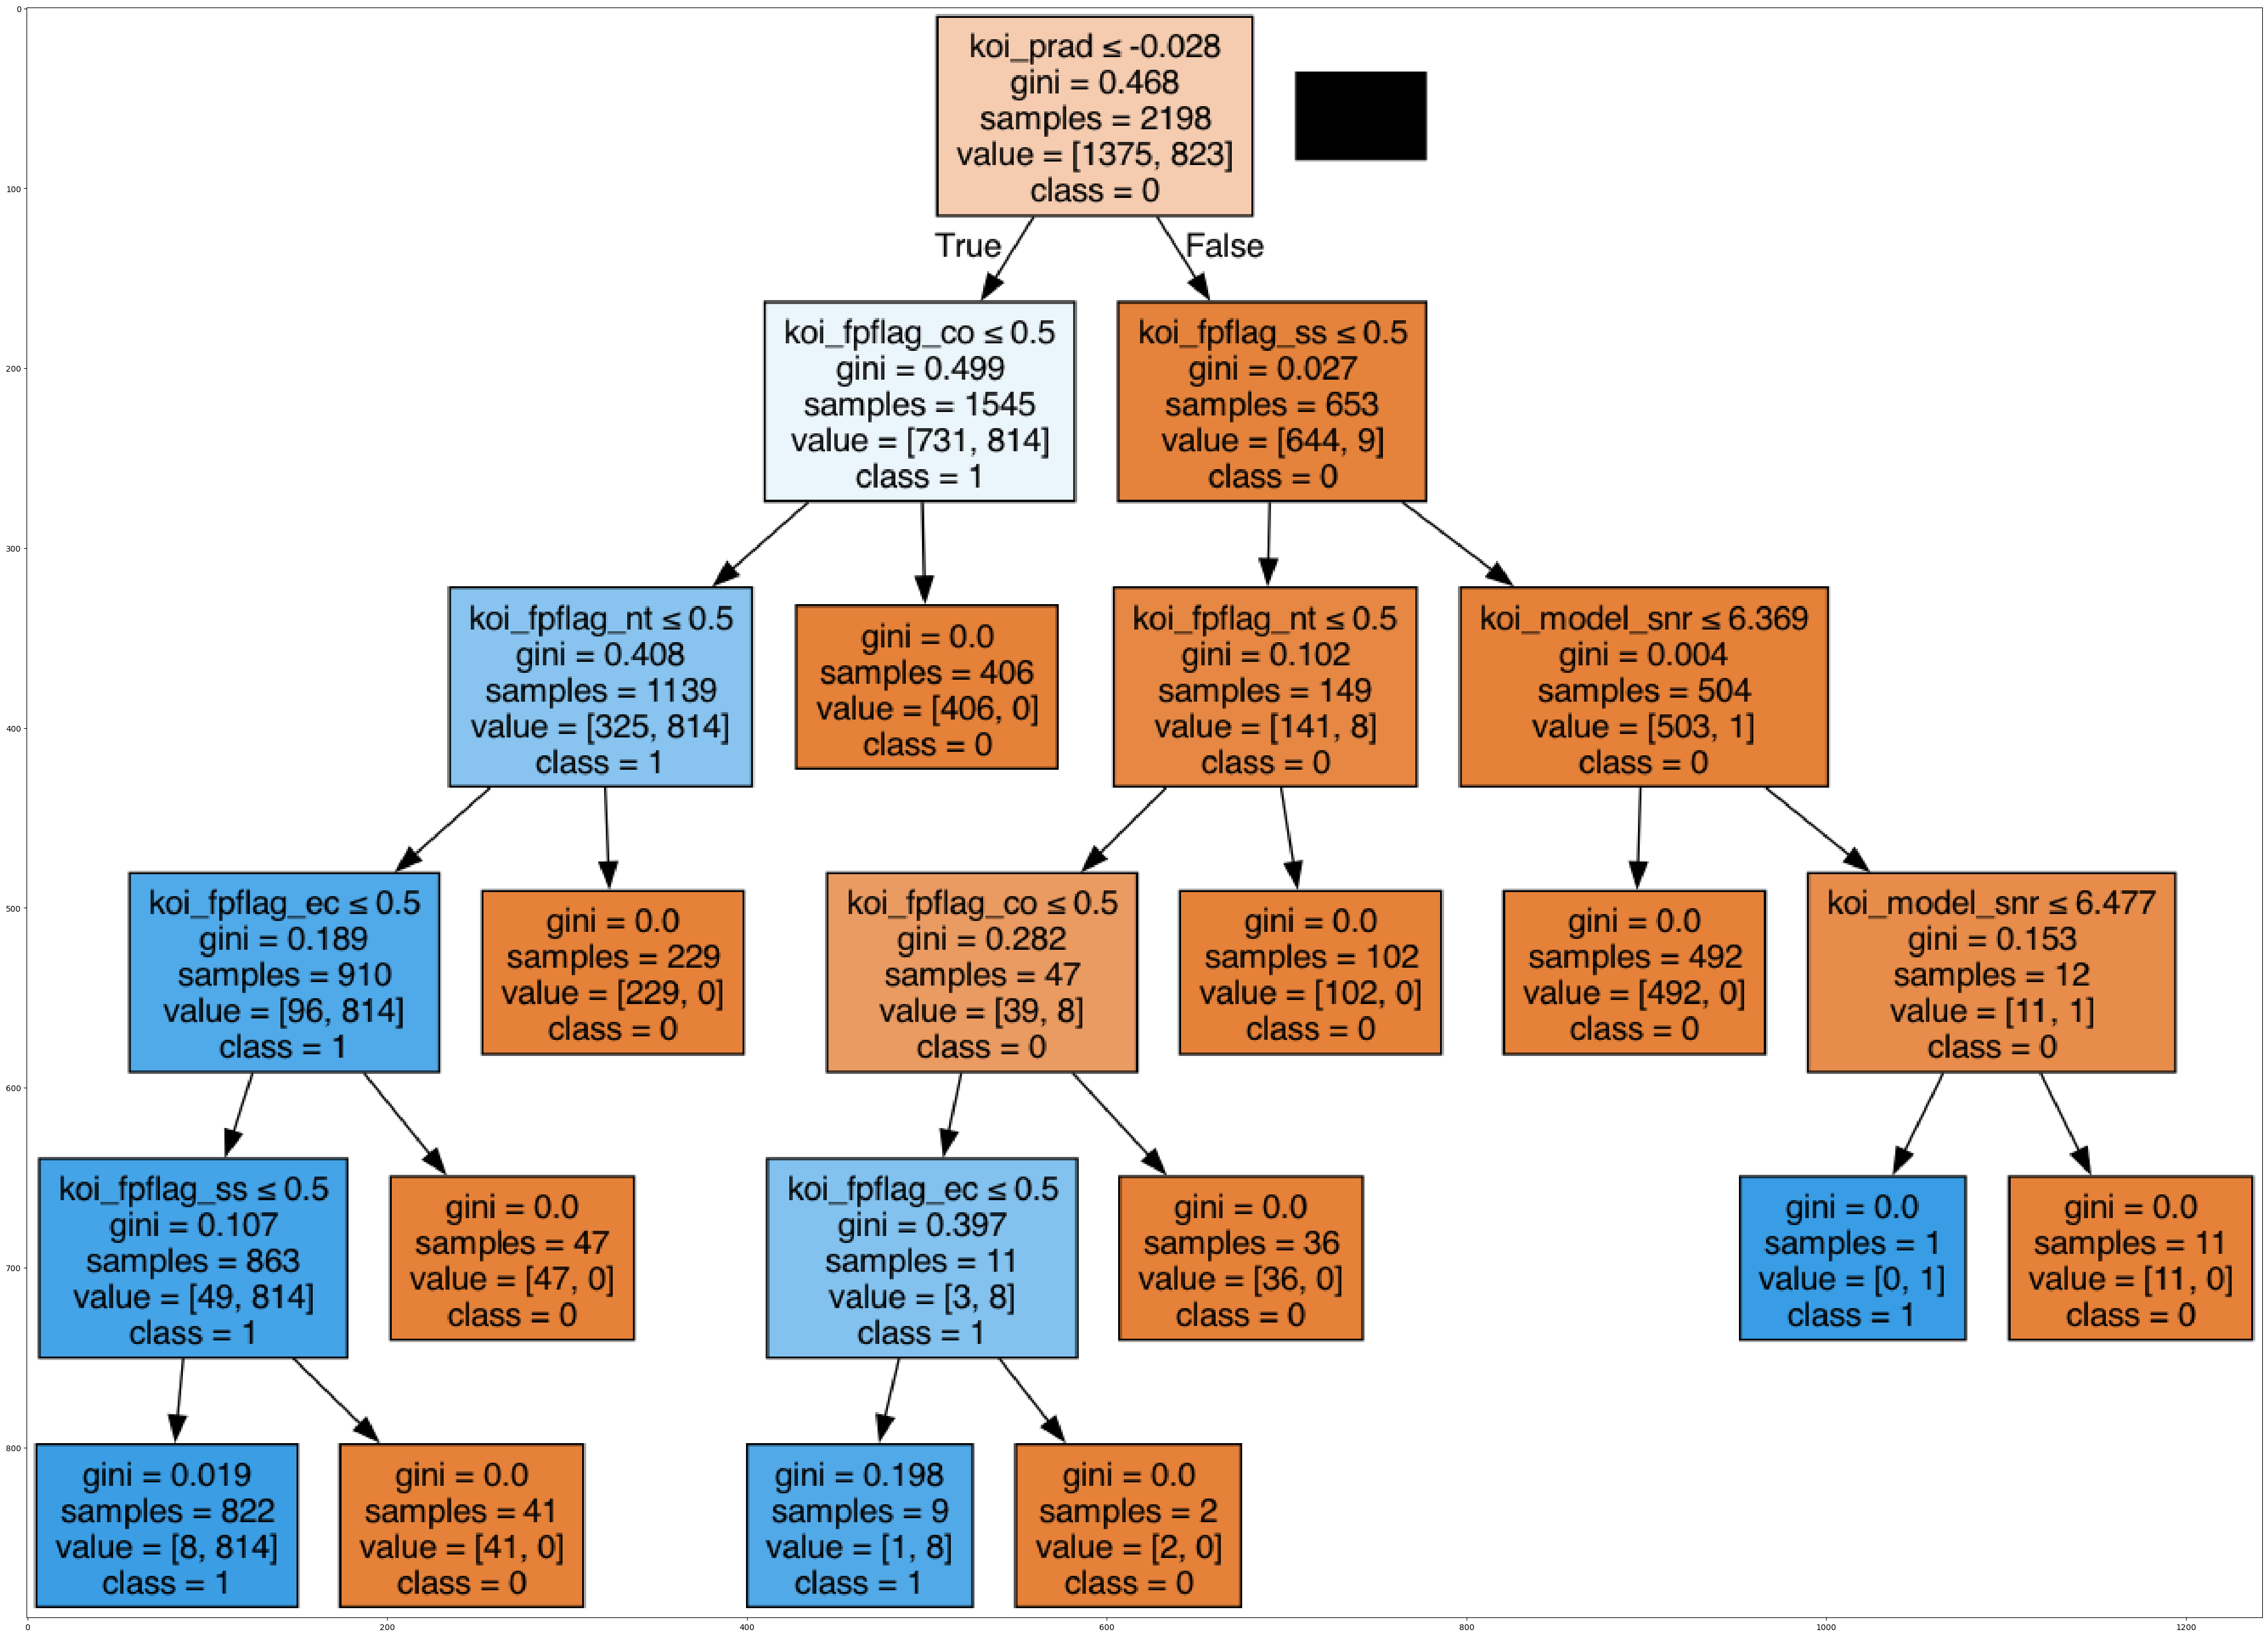

In [232]:
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

def plot_tree(model, feature_names, class_names, filename = "tree.png"):

    dot_data = StringIO()
  
    out=tree.export_graphviz(model, 
                             feature_names=feature_names, 
                             out_file=dot_data, 
                             class_names=class_names, 
                             filled=True, 
                             special_characters=True,
                             rotate=False)
    
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(filename)
    img = mpimg.imread(filename)
    plt.figure(figsize=(50, 100))
    plt.imshow(img, interpolation='nearest')
    plt.show()

plot_tree(tree_surrogate, list(X_test.columns), ['0', '1'], filename = "KOI_surrogate_tree.png")

# Stacking / Voting classifier

In [169]:
# Now let's stack the two good predictors (gradient boost and logistic regression)

estimators = [('KNN', knn_best), ('SVC', svc_best), ('RF', rf_best)]

VC = VotingClassifier(estimators, voting='hard')
VC = VC.fit(X_train, y_train)
y_pred = VC.predict(X_test)

print('Voting classifier:')
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = ', accuracy) 
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
print('Precision = ', precision) 
print('Recall = ', recall) 
print('f1 score = ', f1) 

Voting classifier:
Accuracy =  0.9936305732484076
Precision =  [0.99707816 0.98793727]
Recall =  [0.99272727 0.99513973]
f1 score =  [0.99489796 0.99152542]


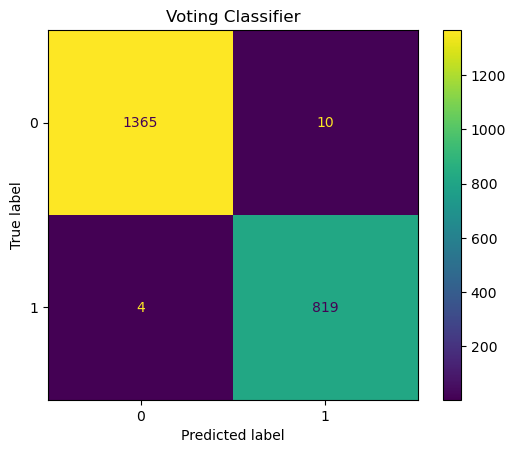

In [170]:
cf = confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=['0', '1'])
disp.plot()
plt.title('Voting Classifier')
plt.show()

# Apply best model to 'CANDIDATE' set and create list of most likely candidates

In [182]:
# Try best model but trained without any of the categorical features?
# Apply best model to the unclassified 'Candidate' set

koi_p.head()
final_predictions = pd.Series(rf_best.predict(koi_p), index=koi_p.index)
print(final_predictions.value_counts())
exoplanet_index = final_predictions[final_predictions == 1].index.tolist()
kepid_list = []
for ix in exoplanet_index:
    kepid_list.append(koi_df.loc[ix, 'kepid'])
print('First few IDs:', kepid_list[:5])

1    1513
0     363
Name: count, dtype: int64
First few IDs: [10811496, 11818800, 11918099, 9579641, 3115833]


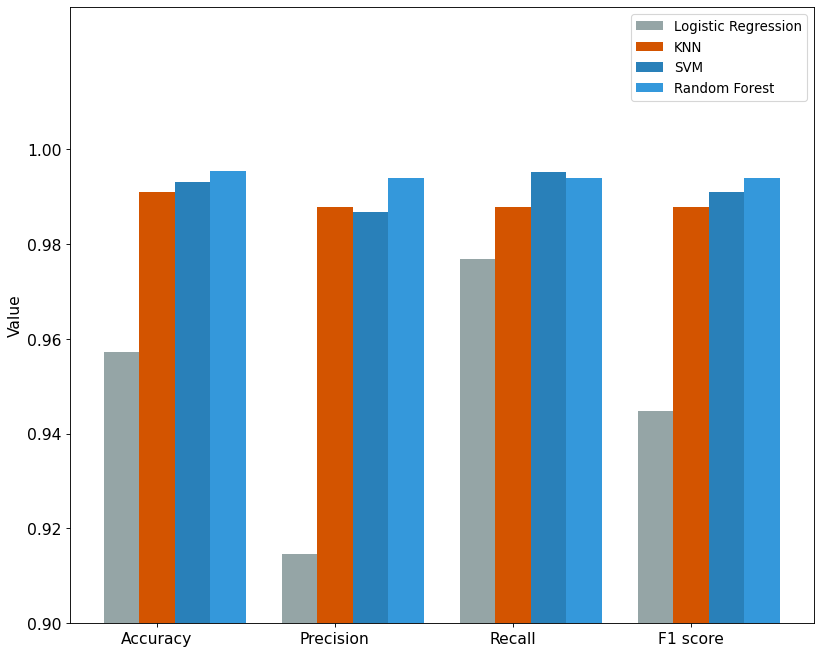

In [241]:
def visualize_eval_metrics(results):
    x = np.arange(4)
    lr = list(model_results[0])
    knn = list(model_results[1])
    svm = list(model_results[2])
    rf = list(model_results[3])
    width = 0.2
    plt.figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, lr, width, color='#95a5a6')
    plt.bar(x, knn, width, color='#d35400')
    plt.bar(x+0.2, svm, width, color='#2980b9')
    plt.bar(x+0.4, rf, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Precision', 'Recall', 'F1 score'], fontsize=14)
    plt.yticks([0.9, 0.92, 0.94, 0.96, 0.98, 1.0], fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.ylim(0.9, 1.03)
    plt.legend(["Logistic Regression", "KNN", "SVM", "Random Forest"], fontsize=12)
    plt.savefig("comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

visualize_eval_metrics(model_results)